# Simulating and fitting multiple voxels with varying initial conditions

In [1]:
from dmipy.data.saved_acquisition_schemes import wu_minn_hcp_acquisition_scheme
acq_scheme = wu_minn_hcp_acquisition_scheme()

## Simulating N-dimensional datasets with varying parameters

For real applications, we may need to simulate data with many different initial conditions, or fit a real dataset where we want to give a voxel-dependent initial condition to avoid local minima. The toolbox allows you to do both these things by generating a multi-dimensional parameter vector.

As an example, we will generate a simple Ball & Stick model.

In [2]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
stick = cylinder_models.C1Stick()
ball = gaussian_models.G1Ball()
ball_and_stick = MultiCompartmentModel(models=[ball, stick])
ball_and_stick.parameter_cardinality

OrderedDict([('G1Ball_1_lambda_iso', 1),
             ('C1Stick_1_mu', 2),
             ('C1Stick_1_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

Now say we want to simulate the signal in each voxel to have the same lambdas and partial_volume, but varying 10x10 grid of $\mu$. This can be done by giving parameters_to_parameter vector just the single value you want for the lambdas and partial_volume, but the mu as a 10x10x2 array.

In [3]:
import numpy as np
lambda_par = np.random.rand() * 1e-9
lambda_iso = lambda_par * 2.
partial_volume = 0.5
mu_array = np.random.rand(10, 10, 2)

gt_parameter_vector = (
    ball_and_stick.parameters_to_parameter_vector(
        C1Stick_1_lambda_par=lambda_par,
        G1Ball_1_lambda_iso=lambda_iso,
        C1Stick_1_mu=mu_array,
        partial_volume_0=partial_volume,
        partial_volume_1=partial_volume)
)

print 'ND parameter vector shape:', gt_parameter_vector.shape
print 'Parameters of first two voxels:'
print gt_parameter_vector[0, :2]

ND parameter vector shape: (10, 10, 6)
Parameters of first two voxels:
[[  5.21618802e-10   9.64593297e-01   8.17844887e-01   2.60809401e-10
    5.00000000e-01   5.00000000e-01]
 [  5.21618802e-10   5.58099709e-01   4.38288666e-01   2.60809401e-10
    5.00000000e-01   5.00000000e-01]]


In [4]:
# the data can now be generated exactly as before.
E_array = ball_and_stick.simulate_signal(acq_scheme, gt_parameter_vector)
print E_array.shape

(10, 10, 288)


## Fitting N-dimensional data with varying initial condition

To give an initial guess for only some parameters we can use the function "parameter_initial_guess_to_parameter_vector". It works example the same as the previous "parameters_to_parameter_vector", but fills "None" in the parameter vector for unaccounted parameters.

First, it is important to realize that by giving an initial condition that the optimizer will try to find a global optimum of all other parameters *given* the initial guess parameters, and then polish the result for a local minimum. First, to see how this works we can give an initial guess that our Stick model is aligned with some random orientation, and actually the ground truth orientation.

In [5]:
random_initial_mu = np.random.rand(10, 10, 2)
parameter_guess_random_mu = (
    ball_and_stick.parameter_initial_guess_to_parameter_vector(C1Stick_1_mu=random_initial_mu)
)

true_initial_mu = mu_array
parameter_guess_true_mu = (
    ball_and_stick.parameter_initial_guess_to_parameter_vector(C1Stick_1_mu=true_initial_mu)
)
print 'ND parameter vector shape:', parameter_guess_random_mu.shape
print 'Parameters of first two voxels:'
print parameter_guess_random_mu[0, :2]

ND parameter vector shape: (10, 10, 6)
Parameters of first two voxels:
[[None 0.722598818211424 0.11599794435901156 None None None]
 [None 0.8829538391605147 0.3411344205245743 None None None]]


Notice how only the mu parameters have a value and the rest is None.  
We can then fit the data with our standard brute2fine optimizer and sample the remaining parameters at 5 equal points between their respective parameter_ranges.

In [6]:
BAS_fit_random = ball_and_stick.fit(acq_scheme, E_array, parameter_guess_random_mu, Ns=5)
BAS_fit_true = ball_and_stick.fit(acq_scheme, E_array, parameter_guess_true_mu, Ns=5)

Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.00029993057251 seconds
Fitting of 100 voxels complete in 1.18870615959 seconds.
Average of 0.0118870615959 seconds per voxel.
Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.000287055969238 seconds
Fitting of 100 voxels complete in 1.06285691261 seconds.
Average of 0.0106285691261 seconds per voxel.


If we then visualize the fitting error:

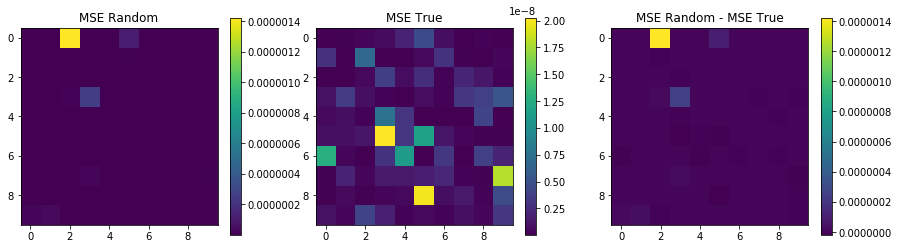

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

mse_random = BAS_fit_random.mean_squared_error(E_array)
mse_true = BAS_fit_true.mean_squared_error(E_array)

fig, axs = plt.subplots(1, 3, figsize=[15, 5])
cf = axs[0].imshow(mse_random)
axs[0].set_title('MSE Random')
fig.colorbar(cf, ax=axs[0], shrink=0.8)
cf = axs[1].imshow(mse_true)
axs[1].set_title('MSE True')
fig.colorbar(cf, ax=axs[1], shrink=0.8)
cf = axs[2].imshow(mse_random - mse_true)
axs[2].set_title('MSE Random - MSE True')

fig.colorbar(cf, ax=axs[2], shrink=0.8)

You can see that some voxels find the wrong local minimum with the random orientation guess - resulting in high fitting errors, and the true guess always finds the global minimum (to the solver tolerance).

## Parameter Cascading - Preparing a complex model with a simple model

The idea of parameter cascading is simple: we find some good initial guesses for parameters using some simpler models, and then put these guesses into a complex model to help it better find a global minimum.

As an example, we use dipy's DTI module to get the initial guess for orientation:

In [8]:
from dipy.reconst import dti
from dmipy.core.acquisition_scheme import gtab_mipy2dipy

# convert dmipy acquisition scheme to dipy gradient table
gtab = gtab_mipy2dipy(acq_scheme)
# initialize the dti model
tenmod = dti.TensorModel(gtab)
# fit the dti model
tenfit = tenmod.fit(E_array)
# get the estimated eigenvectors of the DTI tensor
evecs = tenfit.evecs
# the principal eigenvector is our initial guess for the Stick model orientation
evecs_principal = evecs[..., 0]
evecs_principal.shape

(10, 10, 3)

We then estimate the spherical angles from the cartesian ones

In [9]:
from dmipy.utils.utils import cart2mu
mu_dti = cart2mu(evecs_principal)

and do the same as before

Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.000297069549561 seconds
Fitting of 100 voxels complete in 1.14823889732 seconds.
Average of 0.0114823889732 seconds per voxel.


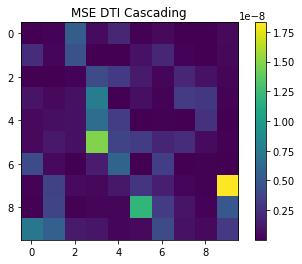

In [10]:
parameter_guess_dti_mu = (
    ball_and_stick.parameter_initial_guess_to_parameter_vector(C1Stick_1_mu=mu_dti)
)
BAS_fit_dti = ball_and_stick.fit(acq_scheme, E_array, parameter_guess_dti_mu, Ns=5)
mse_dti_mu = BAS_fit_dti.mean_squared_error(E_array)

plt.imshow(mse_dti_mu)
plt.title("MSE DTI Cascading")
plt.colorbar()

We can see we that using DTI cascading we have similar results as giving the ground truth orientations (as we did before)

This process is the same for any other paramater, e.g. using CSD to initialize multiple orientations.

NOTE: currently dmipy does not accept initial conditions for volume fractions, but everything else is fine.